In [1]:
# run initial imports
from __future__ import print_function
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

from fbprophet import Prophet
from fbprophet.plot import plot_plotly

import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.express as px
import plotly.graph_objs as go
import seaborn as sns

from scipy.integrate import odeint
from scipy.optimize import curve_fit

from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets import widgets

from datetime import datetime
import os

# if on virtual frame buffer (e.g. headless server)
import plotly.io as pio
pio.orca.config.use_xvfb = True

In [2]:
NOW = datetime.now().strftime("%Y/%m/%d %H:%M")
NOW_FILE = datetime.now().strftime("%Y_%m_%d__%H%M")
pDay=3 # number of corecast days - should not exceed 5 unless you are very careful in tuning, and understand how to interpert the results
input_dir = './data/'
covid_19 = pd.read_csv(input_dir + 'combined.csv')
#correct date parsing on some of the JH data
covid_19['Last Update'] = pd.to_datetime(pd.to_datetime(covid_19['Last Update']).dt.date)
covid_19 = covid_19.sort_values(['Last Update', 'Country/Region'])
covid_19['Country/Region'] = covid_19['Country/Region'].replace({
    'Korea, South': 'South Korea',
    'Republic of Korea': 'South Korea',
    'Iran (Islamic Republic of)': 'Iran',
    'Mainland China': 'China',
    'United Kingdom': 'UK',
}).str.replace('*', '').str.replace(', The', '')

In [3]:
countries = covid_19['Country/Region'].unique()
countries.sort()
print('Available Countries:', countries)

Available Countries: ['Afghanistan' 'Albania' 'Algeria' 'Andorra' 'Angola'
 'Antigua and Barbuda' 'Argentina' 'Armenia' 'Aruba' 'Australia' 'Austria'
 'Azerbaijan' 'Bahamas' 'Bahrain' 'Bangladesh' 'Barbados' 'Belarus'
 'Belgium' 'Belize' 'Benin' 'Bhutan' 'Bolivia' 'Bosnia and Herzegovina'
 'Botswana' 'Brazil' 'Brunei' 'Bulgaria' 'Burkina Faso' 'Burma' 'Burundi'
 'Cabo Verde' 'Cambodia' 'Cameroon' 'Canada' 'Cape Verde' 'Cayman Islands'
 'Central African Republic' 'Chad' 'Channel Islands' 'Chile' 'China'
 'Colombia' 'Comoros' 'Congo (Brazzaville)' 'Congo (Kinshasa)'
 'Costa Rica' "Cote d'Ivoire" 'Croatia' 'Cruise Ship' 'Cuba' 'Curacao'
 'Cyprus' 'Czech Republic' 'Czechia' 'Denmark' 'Diamond Princess'
 'Djibouti' 'Dominica' 'Dominican Republic' 'East Timor' 'Ecuador' 'Egypt'
 'El Salvador' 'Equatorial Guinea' 'Eritrea' 'Estonia' 'Eswatini'
 'Ethiopia' 'Faroe Islands' 'Fiji' 'Finland' 'France' 'French Guiana'
 'Gabon' 'Gambia' 'Georgia' 'Germany' 'Ghana' 'Gibraltar' 'Greece'
 'Greenland' '

In [4]:
#quick national overview
covid_19_countries = covid_19.copy().groupby(['Last Update','Country/Region'])['Confirmed','Deaths', 'Recovered'].sum().reset_index()
covid_19_overall = covid_19.copy().groupby(['Last Update'])['Confirmed','Deaths', 'Recovered'].sum().reset_index()

In [5]:
us_state_abbrev = { 'U.S':'US',
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ','Arkansas': 'AR','California': 'CA','Colorado': 'CO','Connecticut': 'CT','Delaware': 'DE','District of Columbia': 'D.C.','Florida': 'FL','Georgia': 'GA','Hawaii': 'HI','Idaho': 'ID','Illinois': 'IL','Indiana': 'IN','Iowa': 'IA','Kansas': 'KS','Kentucky': 'KY','Louisiana': 'LA','Maine': 'ME','Maryland': 'MD','Massachusetts': 'MA','Michigan': 'MI','Minnesota': 'MN','Mississippi': 'MS','Missouri': 'MO',
    'Montana': 'MT','Nebraska': 'NE','Nevada': 'NV','New Hampshire': 'NH','New Jersey': 'NJ','New Mexico': 'NM','New York': 'NY','North Carolina': 'NC','North Dakota': 'ND','Northern Mariana Islands':'MP','Ohio': 'OH','Oklahoma': 'OK','Oregon': 'OR','Palau': 'PW','Pennsylvania': 'PA',
    'Puerto Rico': 'PR','Rhode Island': 'RI','South Carolina': 'SC','South Dakota': 'SD','Tennessee': 'TN','Texas': 'TX','Utah': 'UT','Vermont': 'VT','Virgin Islands': 'VI','Virginia': 'VA','Washington': 'WA','West Virginia': 'WV','Wisconsin': 'WI','Wyoming': 'WY'
}

In [6]:
top_gdp = {
    'US', 'China', 'Japan', 'Germany', 'India', 'UK', 'France', 'Brazil', 'Italy', 'Canada'
}
next_top_gdp = {
    'Russia', 'South Korea', 'Australia', 'Spain', 'Mexico', 'Indonesia', 'Turkey', 'Netherlands', 'Saudi Arabia', 'Switzerland'
}

In [7]:
wb_stats = pd.read_csv('./reference/wb_population.csv')

In [8]:
covid_19_full_metadata = pd.merge(covid_19, wb_stats, left_on='Country/Region', right_on='Country', how='left')

In [34]:
class suppress_stdout_stderr(object):
    '''
    A context manager for doing a "deep suppression" of stdout and stderr in
    Python, i.e. will suppress all print, even if the print originates in a
    compiled C/Fortran sub-function.
       This will not suppress raised exceptions, since exceptions are printed
    to stderr just before a script exits, and after the context manager has
    exited (at least, I think that is why it lets exceptions through).

    '''
    def __init__(self):
        # Open a pair of null files
        self.null_fds = [os.open(os.devnull, os.O_RDWR) for x in range(2)]
        # Save the actual stdout (1) and stderr (2) file descriptors.
        self.save_fds = [os.dup(1), os.dup(2)]

    def __enter__(self):
        # Assign the null pointers to stdout and stderr.
        os.dup2(self.null_fds[0], 1)
        os.dup2(self.null_fds[1], 2)

    def __exit__(self, *_):
        # Re-assign the real stdout/stderr back to (1) and (2)
        os.dup2(self.save_fds[0], 1)
        os.dup2(self.save_fds[1], 2)
        # Close the null files
        for fd in self.null_fds + self.save_fds:
            os.close(fd)
            
def cleanStr(s):
    c = s.lower().replace(' ', '_')
    c = c.replace('*', '').replace('(', '_').replace(')', '_').replace(',', '_')
    c = c.strip()
    return c

def getDf(country):
    c = cleanStr(country)
    
    totals = covid_19_countries[covid_19_countries['Country/Region'] == country].copy()
    cases = covid_19[covid_19['Country/Region'] == country].copy()
    #let's clean up some bad reporting first
    cases['Province/State'] = cases['Province/State'].str.rsplit(',').str[-1].str.strip()
    cases['Province/State'] = cases['Province/State'].replace(us_state_abbrev)
    cases = cases.groupby(['Last Update','Country/Region', 'Province/State'])['Confirmed','Deaths', 'Recovered'].sum().reset_index()
    
    #correct date parsing on some of the JH data
    cases['Date'] = pd.to_datetime(cases['Last Update'])
    totals['Date'] = pd.to_datetime(totals['Last Update'])
    
    #some backwards compat redundancy
    cases['Death'] = cases['Deaths']
    cases['Active Cases'] = cases['Confirmed'] - cases['Deaths'] - cases['Recovered']
    totals['Death'] = totals['Deaths']
    totals['Active Cases'] = totals['Confirmed'] - totals['Deaths'] - totals['Recovered']
    
    cases = cases.sort_values('Date')
    totals = totals.sort_values('Date')
    
    cases = cases[cases['Confirmed'] > 0]
    return cases, totals

def analyze_country(country):
    cases, totals = getDf(country)
    
    # totals overall
    totals_state = totals[['Date', 'Active Cases', 'Recovered', 'Death']].melt(id_vars=['Date'], 
            value_vars=['Active Cases', 'Death', 'Recovered'], value_name="Population", var_name='Status')
    totals_chart = px.bar(totals_state, 
        x="Date", y="Population", color="Status", title=country+" Active, Recovered and Deaths by Date as of " + str(NOW))
    totals_chart.show()
    totals_chart.write_image("images/" + NOW_FILE + "__" + cleanStr(country) + "active_recoverd_death.png")

def sim_country(country, pop_factor=100, b=0.3, g=1/36, dr=0.035, t=90):
    cases, totals = getDf(country)
    
    N = cases['Confirmed'].max() * pop_factor
    T=t
    I0, R0 = 1000, 20
    S0 = N - I0 - R0
    beta, gamma = b, g
    t = np.linspace(0, T, T)
    y0 = S0, I0, R0

    #SIR Deriv
    def deriv(y, t, N, beta, gamma):
        S, I, R = y
        dSdt = -beta * S * I / N
        dIdt = beta * S * I / N - gamma * I
        dRdt = gamma * I
        return dSdt, dIdt, dRdt

    ret = odeint(deriv, y0, t, args=(N, beta, gamma))
    S, I, R = ret.T

    D = (I/1000000) * dr #totals['Death Rate'].mean()
    R = (R/1000000) - D
    dc = (np.max(D)*1000000)

    fig = plt.figure(figsize=(24,7), facecolor='w')
    ax = fig.add_subplot(111, axisbelow=True)
    ax.plot(t, S/1000000, 'b', alpha=0.5, lw=2, label='Susceptible')
    ax.plot(t, I/1000000, 'r', alpha=0.5, lw=2, label='Infected')
    ax.plot(t, D, 'y', alpha=0.5, lw=2, label='Dead')
    ax.plot(t, R, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
    ax.set_xlabel('Time /days')
    ax.set_title(country.upper() + ' SIR+d model based on known disease characteristics and response at: '+str(NOW) + 
                '\nTotal Infected: '+'{:,.0f}'.format(int(np.max(S)))+
                '\nTotal Recovered: '+'{:,.0f}'.format(int(np.max(R)*1000000))+
                '\nTotal Dead: '+'{:,.0f}'.format(int(np.max(D)*1000000)),
                loc='left'
                )
    #ax.set_ylabel('Number (1000s)')
    #ax.set_ylim(0,1.2)
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    plt.show()

def sim_state(country, state, pop_factor=100, b=0.3, g=1/36, dr=0.035, t=90):
    cases, totals = getDf(country)
    if country != state:
        cases = cases[cases['Province/State'] == state]
    cases = cases.sort_values('Date')
    cases['New Cases'] = cases['Confirmed'].diff()
    cases['New Deaths'] = cases['Deaths'].diff()
    cases = cases.fillna(0)
    cases['Active'] = cases['Confirmed'] - cases['Deaths'] - cases['Recovered']
    cases = cases.fillna(0)
    
    cases['Rolling New'] = cases['New Cases'].rolling(7).mean().fillna(0)
    
    N = cases['Confirmed'].max() * pop_factor
    T=t
    I0, R0 = 1000, 20
    S0 = N - I0 - R0
    beta, gamma = b, g
    t = np.linspace(0, T, T)
    y0 = S0, I0, R0

    #SIR Deriv
    def deriv(y, t, N, beta, gamma):
        S, I, R = y
        dSdt = -beta * S * I / N
        dIdt = beta * S * I / N - gamma * I
        dRdt = gamma * I
        return dSdt, dIdt, dRdt

    ret = odeint(deriv, y0, t, args=(N, beta, gamma))
    S, I, R = ret.T

    D = (I/1000000) * dr #totals['Death Rate'].mean()
    R = (R/1000000) - D
    dc = (np.max(D)*1000000)

    fig = plt.figure(figsize=(24,7), facecolor='w')
    ax = fig.add_subplot(111, axisbelow=True)
    ax.plot(t, S/1000000, 'b', alpha=0.5, lw=2, label='Susceptible')
    ax.plot(t, I/1000000, 'r', alpha=0.5, lw=2, label='Infected')
    ax.plot(t, D, 'y', alpha=0.5, lw=2, label='Dead')
    ax.plot(t, R, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
    ax.set_xlabel('Time /days')
    ax.set_title(state.upper() + ', ' + country.upper() + '' + ' SIR+d model based on known disease characteristics and response at: '+str(NOW) + 
                '\nTotal Infected: '+'{:,.0f}'.format(int(np.max(S)))+
                '\nTotal Recovered: '+'{:,.0f}'.format(int(np.max(R)*1000000))+
                '\nTotal Dead: '+'{:,.0f}'.format(int(np.max(D)*1000000)),
                loc='left'
                )
    #ax.set_ylabel('Number (1000s)')
    #ax.set_ylim(0,1.2)
    ax.yaxis.set_tick_params(length=0)
    ax.xaxis.set_tick_params(length=0)
    ax.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
        ax.spines[spine].set_visible(False)
    plt.show()

def pred_country(country, t=90, infectivity_factor=180, gMethod='linear', disp=True):
    cases, totals = getDf(country)
    
    # now let's run the forecast with fbprophet
    fb_df = totals[['Date', 'Active Cases']].copy()
    fb_df = fb_df.sort_values('Date').reset_index(drop=True)
    fb_df.columns = ['ds','y']
    #fb_df['cap'] = totals['Death'] * infectivity_factor
    cap = fb_df['y'].max() * 2
    fb_df['floor'] = 0
    fb_df['cap'] = cap
    #print(fb_df)

    with suppress_stdout_stderr():
        m = Prophet(yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False, growth='logistic', 
            interval_width=0.97,
            n_changepoints=6, 
            changepoint_prior_scale=0.5)
        m.add_country_holidays(country_name='US')
        m.add_seasonality(name='daily', period=1, fourier_order=3, mode='additive')
        m.add_seasonality(name='weekly', period=14, fourier_order=28, mode='additive')
        m.fit(fb_df)
        future = m.make_future_dataframe(periods=t)
        #future['cap'] = totals['Death'].max() * infectivity_factor
        future['floor'] = 0
        future['cap'] = cap
        forecast = m.predict(future)
        py.init_notebook_mode()

        fig = plot_plotly(m, forecast, xlabel='Date', ylabel='Active Cases', uncertainty=True, figsize=(1100,600))  # This returns a plotly Figure
        fig.update_layout(title='Active '+country+' COVID-19 Cases and Forecast ('+str(t)+' day) as of ' + str(NOW))

        c = cleanStr(country)
        os.makedirs("./images/" + c + "/" + NOW_FILE, exist_ok=True)
        fig.write_image("./images/" + c + "/" + NOW_FILE + "/" + NOW_FILE + "__" + c + "_forecast_" + str(t) + "_day.png")

        if disp:
            py.iplot(fig)

def pred_province(country, province, t=90, infectivity_factor=180, gMethod='linear', disp=True, value='Confirmed'):
    cases, totals = getDf(country)
    if country != province:
        cases = cases[cases['Province/State'] == province]
    cases = cases.sort_values('Date')
    cases['New Cases'] = cases['Confirmed'].diff()
    cases['New Deaths'] = cases['Deaths'].diff()
    cases = cases.fillna(0)
    cases['Active'] = cases['Confirmed'] - cases['Deaths'] - cases['Recovered']
    cases = cases.fillna(0)
    
    cases['Rolling New'] = cases['New Cases'].rolling(7).mean().fillna(0)
    
    #print('Total records so far: ', totals.shape[0])
    # now let's run the forecast with fbprophet
    fb_df = cases[['Date', value]].copy()
    fb_df = fb_df.sort_values('Date').reset_index(drop=True)
    fb_df.columns = ['ds','y']
    #fb_df['cap'] = totals['Death'] * infectivity_factor
    cap = fb_df['y'].max() * 2
    fb_df['floor'] = 0
    fb_df['cap'] = cap
    #print(fb_df)

    with suppress_stdout_stderr():
        m = Prophet(yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False, growth='logistic', 
            interval_width=0.97,
            n_changepoints=6, 
            changepoint_prior_scale=0.5)
        m.add_country_holidays(country_name='US')
        m.add_seasonality(name='daily', period=1, fourier_order=3, mode='additive')
        m.add_seasonality(name='weekly', period=14, fourier_order=28, mode='additive')
        m.fit(fb_df)
        future = m.make_future_dataframe(periods=t)
        #future['cap'] = totals['Death'].max() * infectivity_factor
        future['floor'] = 0
        future['cap'] = cap
        forecast = m.predict(future)
        py.init_notebook_mode()

        fig = plot_plotly(m, forecast, xlabel='Date', ylabel=value, uncertainty=True, figsize=(1100,600))  # This returns a plotly Figure
        fig.update_layout(title=province+', '+country+' '+value+' COVID-19 Cases and Forecast ('+str(t)+' day) as of ' + str(NOW))

        if disp:
            py.iplot(fig)
#     pl = px.bar(cases['Date'], cases['New Cases'])
#     pl.show()
def get_doubling(y):
    ylen = len(y)
    dbl = np.zeros(ylen)
    for i in range( ylen - 1, -1, -1):
        target = y[i]
        count = 0
        for j in range(i, -1, -1):
            diff = target-y[j]
            exact = target / 2
            if diff  > exact:
                f = (exact - y[j]) / (y[j]-y[j+1]) + count
                dbl[i] = f
                break
            else:
                count = count+1
    return dbl
def display_doubling(country, province, remove_zeros=False):
    cases, totals = getDf(country)
    if country != province:
        cases = cases[cases['Province/State'] == province]
    else:
        cases = cases.groupby('Last Update').sum().reset_index()
    cases = cases.sort_values('Last Update')
    
    if remove_zeros:
        cases = cases[cases['Confirmed'] > 0 ]
    
    cases['Doubling'] = get_doubling(cases['Confirmed'].values)
    cases['Doubling Time'] = 1 / np.log2(1+((cases['Confirmed'] - cases['Confirmed'].shift(1)) / cases['Confirmed'].shift(1)))
    
    fig, ax = plt.subplots(figsize=(14, 14))
    ax2 = ax.twinx()

    sns.lineplot(x=cases['Last Update'], y=cases['Doubling'], ax=ax, ci=99.9, color='blue', label='Doubling Time (days)', legend='brief')
    sns.lineplot(x=cases['Last Update'], y=cases['Confirmed'], ax=ax2, ci=99.9, color='red', label='Confirmed Cases', legend='brief')

    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')
    ax2.set(yscale="log") 

def display_log_new_conf(country, province, remove_zeros=False):
    cases, totals = getDf(country)
    if country != province:
        cases = cases[cases['Province/State'] == province]
    else:
        cases = cases.groupby('Last Update').sum().reset_index()
    cases = cases.sort_values('Last Update')
    if remove_zeros:
        cases = cases[cases['Confirmed'] > 0 ]
    
    cases['New Cases'] = cases['Confirmed'].diff()
    
    fig, ax = plt.subplots(figsize=(14, 14))
    ax.set(yscale="log", xscale="log") 
    sns.regplot(x=cases['Confirmed'], y=cases['New Cases'], ax=ax, ci=99.9)

In [32]:
def display_sim(Country, Susceptible_Population_Factor, Infectivity, Infective_Days, Death_Rate, Days):
    sim_country(Country, Susceptible_Population_Factor*100, Infectivity, 1/Infective_Days, Death_Rate/100.0, Days)

def display_sim_state(Country, State, Susceptible_Population_Factor, Infectivity, Infective_Days, Death_Rate, Days):
    sim_state(Country, State, Susceptible_Population_Factor*10, Infectivity, 1/Infective_Days, Death_Rate/100.0, Days)


top_gdp_compare = [i for i in top_gdp if i not in ['China']] # let's pull china due to data discrepancies
countries_lim = [i for i in countries if i not in top_gdp_compare]

def compare_country(country):
    days_set = covid_19[covid_19['days since 100 active - Country/Region'] >= 0].copy()
    t_countries = list(top_gdp_compare.copy())
    t_countries.append(country)
    days_set = days_set[days_set['Country/Region'].isin(t_countries)]
    days_set = days_set.groupby(['days since 100 active - Country/Region', 'Country/Region']).sum().reset_index()
    
    days_set = pd.merge(days_set, wb_stats, left_on='Country/Region', right_on='Country', how='left')
    days_set = days_set.sort_values('days since 100 active - Country/Region')
    days_set['Confirmed'] = days_set['Confirmed'].fillna(0)
    days_set['Cases per 1m'] = ((days_set['Confirmed'] / days_set['Population, total 2018']) * 1000000)
    days_set['Deaths per 1m'] = ((days_set['Deaths'] / days_set['Population, total 2018']) * 1000000)

    world_chart = px.line(days_set, 
                          x="days since 100 active - Country/Region", y="Active", color="Country/Region", 
                          title="Active Cases by Day of Outbreak", log_y=True)
    world_chart.show()
    world_chart = px.line(days_set, 
                          x="days since 100 active - Country/Region", y="Cases per 1m", color="Country/Region", 
                          title="Per Capita Confirmed Cases by Day of Outbreak", log_y=False)
    world_chart.show()
    world_chart = px.line(days_set, 
                          x="days since 100 active - Country/Region", y="Deaths per 1m", color="Country/Region", 
                          title="Per Capita Deaths by Day of Outbreak", log_y=False)
    world_chart.show()


def display_compare_country(Country):
    compare_country(Country)


def display_pred(Country, Days):
    pred_country(Country, Days, infectivity_factor=180, gMethod='logistic')

def display_country(Country):
    analyze_country(Country)

In [11]:
interactive_plot_country = interactive(display_country, Country=countries)
output = interactive_plot_country.children[-1]
output.layout.height = '520px'
output.layout.width = '1200px'
interactive_plot_country

interactive(children=(Dropdown(description='Country', options=('Afghanistan', 'Albania', 'Algeria', 'Andorra',…

In [12]:
interactive_plot_country_forecast = interactive(display_pred, Country=countries, Days=widgets.IntSlider(min=3, max=14, step=1, value=5))
output = interactive_plot_country_forecast.children[-1]
output.layout.height = '600px'
output.layout.width = '1200px'
interactive_plot_country_forecast

interactive(children=(Dropdown(description='Country', options=('Afghanistan', 'Albania', 'Algeria', 'Andorra',…

In [13]:
countryW = widgets.Dropdown(options = countries)

@interact(Country=countryW)
def updateState(Country):
    cases, totals = getDf(Country)
    display_doubling(Country, Country)
    # display_log_new_conf(Country, Country, remove_zeros=False)

interactive(children=(Dropdown(description='Country', options=('Afghanistan', 'Albania', 'Algeria', 'Andorra',…

In [35]:
countryWf = widgets.Dropdown(options = countries)
stateWf = widgets.Dropdown()
daysWf = widgets.IntSlider(min=3, max=30, step=1, value=5)
valueWf = widgets.Dropdown(options = ['Confirmed', 'Active', 'Recovered', 'Deaths', 'New Cases', 'New Deaths', 'Rolling New'])

@interact(Country=countryWf, State=stateWf, Days=daysWf, Value=valueWf)
def updateState(Country, State, Days, Value):
    cases, totals = getDf(Country)
    sts = cases['Province/State'].unique()
    sts.sort()
    stateWf.options = sts
    pred_province(Country, State, Days, infectivity_factor=180, gMethod='logistic', value=Value)

interactive(children=(Dropdown(description='Country', options=('Afghanistan', 'Albania', 'Algeria', 'Andorra',…

In [15]:
countryWd = widgets.Dropdown(options = countries)
stateWd = widgets.Dropdown()

@interact(Country=countryWd, State=stateWd)
def updateState(Country, State):
    cases, totals = getDf(Country)
    sts = cases['Province/State'].unique()
    sts.sort()
    stateWd.options = sts
    #display_log_new_conf(Country, State, False)
    display_doubling(Country, State, False)

interactive(children=(Dropdown(description='Country', options=('Afghanistan', 'Albania', 'Algeria', 'Andorra',…

In [16]:
interactive_plot_sim = interactive(display_sim, Country=countries,
                              Susceptible_Population_Factor=widgets.IntSlider(min=1, max=35, step=1, value=1),
                              Infectivity=widgets.FloatSlider(min=0.01, max=4.000, step=0.01, value=0.15),
                              Infective_Days=widgets.IntSlider(min=2, max=48, step=1, value=28),
                              Death_Rate=widgets.FloatSlider(min=0.3, max=10.0, step=0.1, value=1.2),
                              Days=widgets.IntSlider(min=30, max=365*4, step=1, value=180))

output = interactive_plot_sim.children[-1]
output.layout.height = '540px'
output.layout.width = '1200px'
interactive_plot_sim

interactive(children=(Dropdown(description='Country', options=('Afghanistan', 'Albania', 'Algeria', 'Andorra',…

interactive(children=(Dropdown(description='Country', options=('Afghanistan', 'Albania', 'Algeria', 'Andorra',…

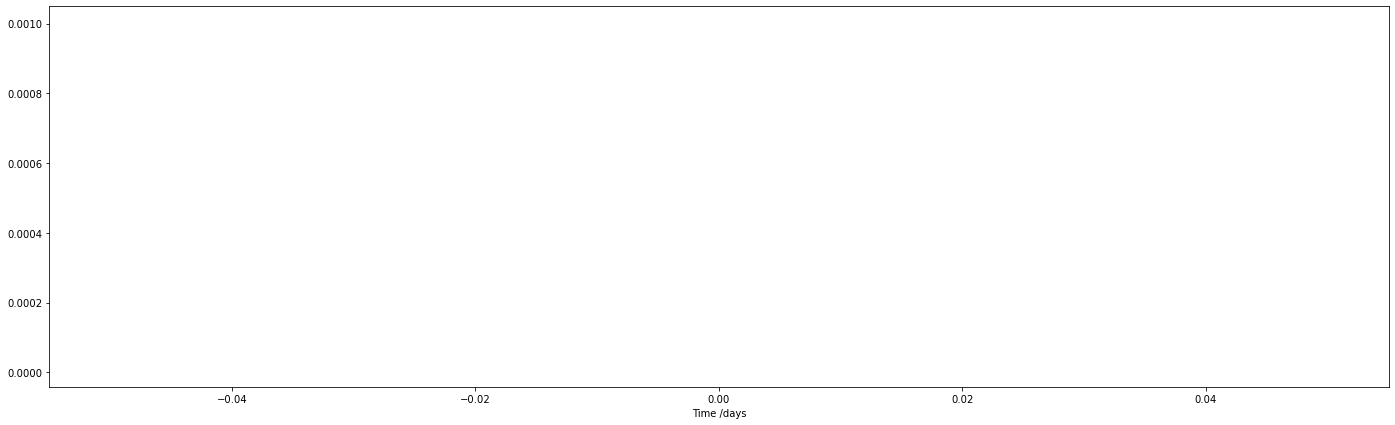

In [33]:
countryWdSim = widgets.Dropdown(options = countries)
stateWdSim = widgets.Dropdown()

@interact(Country=countryWdSim, State=stateWdSim,
          Susceptible_Population_Factor=widgets.IntSlider(min=1, max=35, step=1, value=1),
          Infectivity=widgets.FloatSlider(min=0.01, max=4.000, step=0.01, value=0.15),
          Infective_Days=widgets.IntSlider(min=2, max=48, step=1, value=28),
          Death_Rate=widgets.FloatSlider(min=0.3, max=10.0, step=0.1, value=1.2),
          Days=widgets.IntSlider(min=30, max=365*4, step=1, value=180))
def simState(Country, State, Susceptible_Population_Factor, Infectivity, Infective_Days, Death_Rate, Days):
    cases, totals = getDf(Country)
    sts = cases['Province/State'].unique()
    sts.sort()
    stateWdSim.options = sts
    display_sim_state(Country, State, Susceptible_Population_Factor, Infectivity, Infective_Days, Death_Rate, Days)

In [17]:
interactive_plot_stats = interactive(display_compare_country, Country=countries_lim)
output = interactive_plot_stats.children[-1]
output.layout.height = '1400px'
output.layout.width = '1200px'
interactive_plot_stats

interactive(children=(Dropdown(description='Country', options=('Afghanistan', 'Albania', 'Algeria', 'Andorra',…